# Simple LSTM model

### Variables
- `max_len`: max sentence size in #words
- `n_class`: number of classes, 2 for fake and real news

### Structure
- Pretrained embedding layer
- Two LSTM layers with dropout
- Linear then softmax for one hot vector output, classification probabilities

In [1]:
max_len = 10 # max number of words in a sentence, average+2*std of fake news (longer than real news)
n_class = 2 # 1: fake, 0: not fake

In [2]:
#import freq_utils
from freq_utils import *

#import pandas as pd

pd.options.display.max_colwidth = 200

In [3]:
df0 = pd.read_csv('data/True.csv')
df1 = pd.read_csv('data/Fake.csv')

df0['label'] = 0
df1['label'] = 1

print(len(df0),len(df1))

train, dev, test = train_dev_test_split([df0, df1], m=10000, class_column='label', 
                                    class_balance=True, r_dev=0.2, r_test=0.2, rand_state=42)

21417 23481


In [4]:
word_to_index, index_to_word, word_to_vec_map = get_pretrained_embedding()

In [5]:
def df_to_xy(df, word_to_index, max_len):
    
    #X = df.title.str.replace(r'[^\s\w]', '',regex=True).to_numpy()
    indx = df.index.to_numpy() 
    X = df.title.to_numpy()
    Y = df.label.to_numpy()
    X_indices = sentences_to_indices(X, word_to_index, max_len)
    Y_oh = pd.get_dummies(df['label']).to_numpy()
    
    return indx, X, X_indices, Y, Y_oh

_, X_train, X_train_indices, Y_train, Y_train_oh = df_to_xy(train, word_to_index, max_len)
_, X_dev,   X_dev_indices,   Y_dev,   Y_dev_oh   = df_to_xy(dev, word_to_index, max_len)
indx_test, X_test,  X_test_indices,  Y_test,  Y_test_oh  = df_to_xy(test, word_to_index, max_len)

In [6]:
def simple_LSTM(input_shape, word_to_vec_map, word_to_index, n_class=2):
    '''
    input_shape: (max_len,)
    word_to_vec_map: word to embedding vector dictionary
    word_to_index: word to index dictionary
    
    return model
    
    then
    X: Indices of a sentence (m, max_len)
    Y: Class probability, one hot vector (m, # classes)
    '''
    
    # Input layer
    X_indices = tfl.Input(shape=input_shape, dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable=False)
    X = embedding_layer(X_indices)   
    
    # Masking layer
    # skip zero vector words
    X = tfl.Masking(mask_value=0.)(X)
    
    # LSTM layer
    # Output: a[1] (m, max_len, 128 hidden unit), batch of sequences
    X = tfl.LSTM(units = 128, return_sequences= True)(X)
    X = tfl.Dropout(rate = 0.5 )(X) 
    
    # LSTM layer
    # Output: a[2]<max_len> (m, 128 hidden unit)
    X = tfl.LSTM(units = 128)(X)
    X = tfl.Dropout(rate = 0.5)(X)  

    # Linear layer
    # Output: a[3] (m, # classes)
    X = tfl.Dense(units = n_class)(X)
    
    # Softmax layer
    # Output: y (m, # classes), probability of each class
    X = tfl.Activation('softmax')(X)
    
    # Model
    model = tf.keras.models.Model(inputs=X_indices, outputs=X)
        
    return model

In [7]:
model = simple_LSTM((max_len,), word_to_vec_map, word_to_index, n_class)
model.summary()

2022-02-11 13:01:15.546436: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            20000050  
                                                                 
 masking (Masking)           (None, 10, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [9]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 32, shuffle=True, 
                    validation_data=(X_dev_indices, Y_dev_oh),#)
                    callbacks=[es])

Epoch 1/20
188/188 [==============================] - 15s 48ms/step - loss: 0.3779 - accuracy: 0.8315 - val_loss: 0.3270 - val_accuracy: 0.8565
Epoch 2/20
188/188 [==============================] - 6s 30ms/step - loss: 0.3090 - accuracy: 0.8700 - val_loss: 0.3012 - val_accuracy: 0.8650
Epoch 3/20
188/188 [==============================] - 5s 28ms/step - loss: 0.2736 - accuracy: 0.8873 - val_loss: 0.2944 - val_accuracy: 0.8775
Epoch 4/20
188/188 [==============================] - 5s 28ms/step - loss: 0.2575 - accuracy: 0.8952 - val_loss: 0.2770 - val_accuracy: 0.8810
Epoch 5/20
188/188 [==============================] - 5s 28ms/step - loss: 0.2243 - accuracy: 0.9080 - val_loss: 0.2577 - val_accuracy: 0.8865
Epoch 6/20
188/188 [==============================] - 5s 28ms/step - loss: 0.1987 - accuracy: 0.9207 - val_loss: 0.2517 - val_accuracy: 0.8955
Epoch 7/20
188/188 [==============================] - 5s 29ms/step - loss: 0.1808 - accuracy: 0.9287 - val_loss: 0.2733 - val_accuracy: 0.894

In [10]:
#model.save("my_model")

/Users/minjungkim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


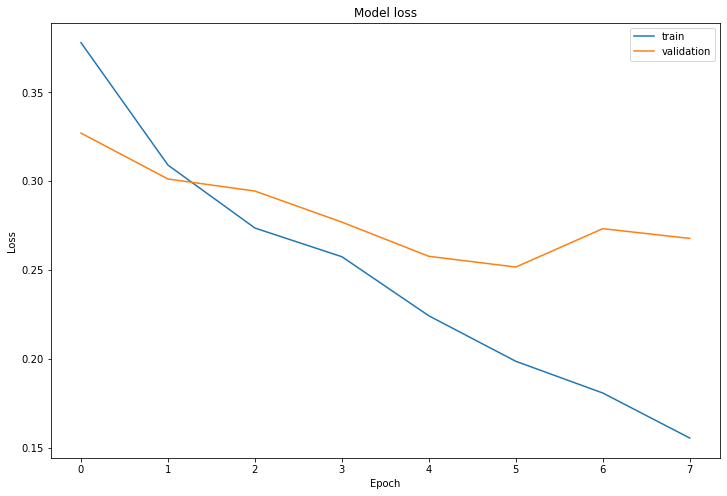

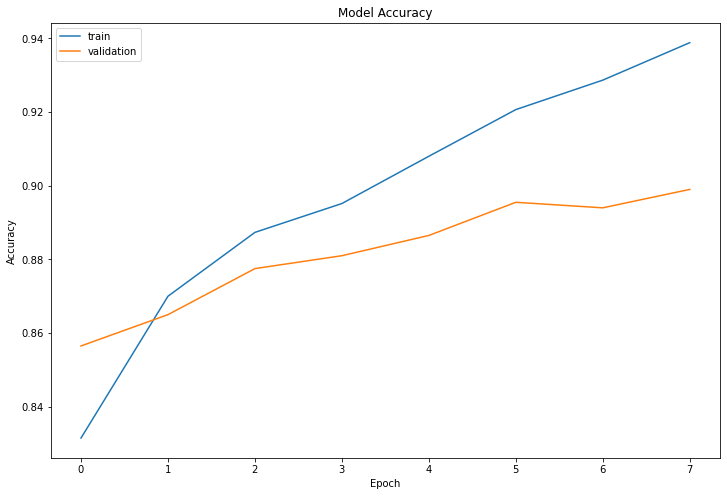

In [11]:
plot_learning_curve(history)

In [12]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)


pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print(X_test[i])
        print('Expected label:'+ str(Y_test[i]))
        print(np.round(pred[i], 3))

63/63 [==============================] - 1s 9ms/step - loss: 0.2787 - accuracy: 0.9055

Test accuracy =  0.9054999947547913
Easily Duped: Trump Surpasses Bush, Falling for ‘Chemical Weapons’ Theatrics
Expected label:1
[0.73 0.27]
Popular Michelle Obama courts young people for Clinton
Expected label:0
[0.005 0.995]
NSA chief on Russia-U.S. cyber unit: Now is 'not the best time'
Expected label:0
[0.014 0.986]
 The United States Government Has Told Trump To Go F*CK Himself
Expected label:1
[0.62 0.38]
 WTF? Trump Demanded Comey’s ‘Loyalty’ At Private Dinner
Expected label:1
[0.859 0.141]
WOW! FORMER AMBASSADOR TO RUSSIA Lists Failures Of OBAMA in Syria [VIDEO]
Expected label:1
[0.627 0.373]
RIDICULOUS! MUSLIMS Chant “Allah” And Protest With Call To Prayer Inside Dallas Airport [Video]
Expected label:1
[0.79 0.21]
TRUMP SHOCKS SUPPORTERS With SURPRISE Visit At Huge Rally Hosted By “Blacks 4 Trump” Near Mar-a-Lago [VIDEO]
Expected label:1
[0.895 0.105]
U.S. citizen on the run after busting 

# Conclusion
- 90% of accuracy in balanced dataset.
- Sign of overfit from 5 epoch.
- Without EDA, we don't know if any bias of dataset played a key role in correct classification. Let's take a look and improve this base model with EDA and hyperparameter tuning.